In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob


## Unfiltered

In [2]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
# file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [3]:
time_subsample = 1
full_dat = data[7500:12500,::time_subsample]

for i in np.arange(12,16):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat = np.hstack((full_dat,data[7500:12500,::time_subsample]))

In [85]:
# # np.arange(11,31).shape

# n = 1.4682
# L = 51.04762
# full_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*full_dat[:,::10]

# # EDIT!!!

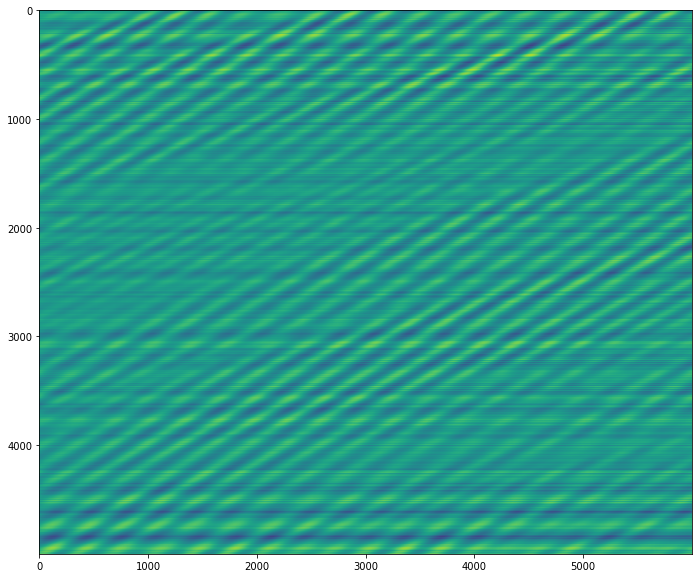

In [5]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat[:,::10])
plt.show()

In [6]:
dt=1. #/200
working_dat = full_dat[:,::10]/np.std(full_dat)#*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

# time = dt*np.arange(working_dat.shape[0])

In [7]:
xs.shape

(5000,)

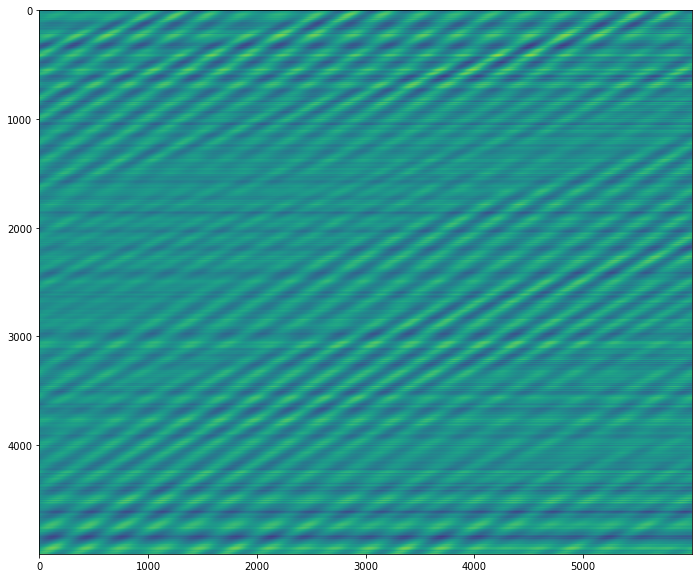

In [8]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [9]:
# library_functions = [lambda x: x, lambda x: x * x]
# library_function_names = [lambda x: x, lambda x: x + x]
# pde_lib = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     derivative_order=4,
#     spatial_grid=xs,
#     include_bias=True,
#     is_uniform=True,
# #     periodic=True
# )

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

### Dataset 1

In [10]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdbd992e6d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [11]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -73.084 x0_111


In [12]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdbd992e6d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [13]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.017 x0_1 + -0.078 x0_11 + -45.924 x0_111


In [14]:
thresh = 0.005
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdbd992e6d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.005))

In [15]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.005
(x0)' = 0.017 x0_1 + -0.042 x0_11 + -46.226 x0_111 + 0.005 x0x0_1


### Dataset 2 (weak formulation)

In [16]:
time_subsample = 10
full_dat = np.zeros((5000,6000))

k = 0
for i in np.arange(21,26):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    


In [17]:
# n = 1.4682
# L = 51.04762
# full_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*full_dat


In [18]:
dt=1. #/200
working_dat = full_dat/np.std(full_dat)#*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

# time = dt*np.arange(working_dat.shape[0])

In [19]:
np.amax(working_dat)

4.3295561489243255

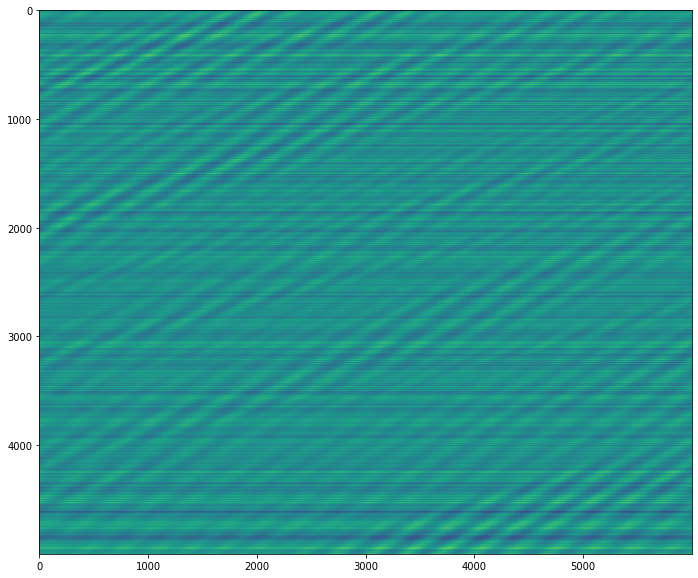

In [20]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [21]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

In [22]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdbd995be80>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [23]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -69.013 x0_111


In [24]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdbd995be80>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [25]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = -0.021 x0_1 + 0.809 x0_11 + -106.347 x0_111 + 0.015 x0x0_1


In [26]:
thresh = 0.005
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdbd995be80>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.005))

In [27]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.005
(x0)' = -0.021 x0_1 + 0.809 x0_11 + -106.347 x0_111 + 0.015 x0x0_1


## Gaussian Filtered



In [54]:
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")

In [55]:
# n = 1.4682
# L = 51.04762
working_dat = np.zeros((5000,6000))
b=0
for q in np.arange(5):
#     if b==0:
#         working_dat = np.load(file_list[q])
#         b=1
#     else:
#         working_dat = np.hstack((working_dat, np.load(file_list[q])))
    working_dat[:,q*(1200):(q+1)*1200] = np.load(file_list[q])[:,::10]
        
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

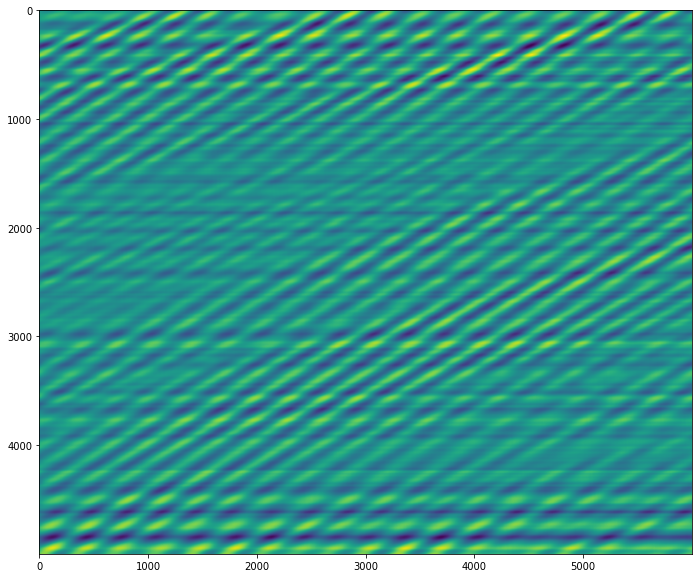

In [56]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [57]:
xs = np.arange(working_dat.shape[0])
print(xs.shape)

(5000,)


In [58]:
# library_functions = [lambda x: x, lambda x: x * x]
# library_function_names = [lambda x: x, lambda x: x + x]
# pde_lib = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     derivative_order=4,
#     spatial_grid=xs,
#     include_bias=True,
#     is_uniform=True,
# #     periodic=True
# )

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

### Dataset 1

In [61]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdb231608e0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=2.0))

In [62]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 2.0
(x0)' = -97.533 x0_111 + 2.477 x0x0x0_111


In [59]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdb231608e0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [60]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -96.554 x0_111 + -3.210 x0x0_111 + 2.066 x0x0x0_111


### Dataset 2

In [69]:
# n = 1.4682
# L = 51.04762
working_dat = np.zeros((5000,6000))
b=0
for q in np.arange(10,15):

    working_dat[:,b*(1200):(b+1)*1200] = np.load(file_list[q])[:,::10]
    b+=1
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

In [70]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdb231608e0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=2.0))

In [71]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 2.0
(x0)' = -71.345 x0_111


In [72]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdb231608e0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [73]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -71.345 x0_111


In [74]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdb231608e0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=50))

In [75]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = -72.494 x0_111 + -1.100 x0x0_111


## Drift Removal Load

In [29]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_11.npy")[:,::10]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [31]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

In [33]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdc10676fa0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [34]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -960.610 x0_111


In [41]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdc10676fa0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=50))

In [42]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = -0.303 x0_11 + -962.162 x0_111 + -0.217 x0x0_111


In [45]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdc10676fa0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [46]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.026 x0_1 + -0.232 x0_11 + -941.118 x0_111 + 0.017 x0x0_1 + -0.038 x0x0x0_1 + -0.021 x0x0x0_11 + 0.544 x0x0_111 + 0.049 x0x0x0_111


### Dataset 2

In [47]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_21.npy")[:,::10]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [48]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdc10676fa0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [49]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -1032.897 x0_111


In [50]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdc10676fa0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=50))

In [51]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = -0.233 x0_1 + -0.188 x0_11 + -1415.671 x0_111 + -0.316 x0x0_111 + -0.618 x0x0x0_111


In [52]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fdc10676fa0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [53]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = -0.228 x0_1 + -0.229 x0_11 + -1414.985 x0_111 + 0.016 x0x0_1 + -0.042 x0x0x0_1 + 0.014 x0x0x0_11 + 0.426 x0x0_111 + -0.851 x0x0x0_111


### drift removal

In [41]:
A_channel = np.hstack((np.arange(full_dat.shape[1]).reshape((-1,1)),np.ones(full_dat.shape[1]).reshape((-1,1))))
coeffs = np.zeros((full_dat.shape[0],2))
for channel in range(full_dat.shape[0]):
    coeffs[channel,:] = np.linalg.lstsq(A_channel, full_dat[channel,:], rcond=None)[0]
    

In [42]:
drift_removal = np.zeros(full_dat.shape)
for channel in range(full_dat.shape[0]):
    drift_removal[channel,:] = full_dat[channel,:]-(coeffs[channel,0]*A_channel[:,0] + coeffs[channel,1])

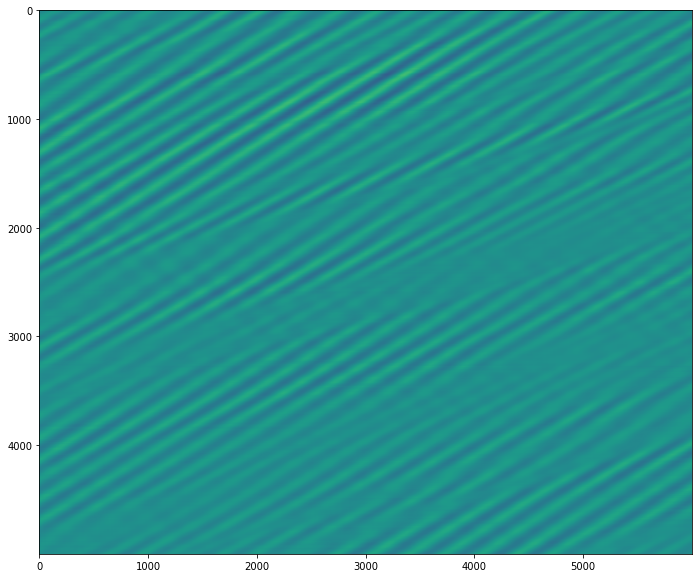

In [43]:
plt.figure(figsize=(12,10))
plt.imshow(drift_removal[:,:]*10**6, vmin=-5.,vmax=5.)
plt.show()

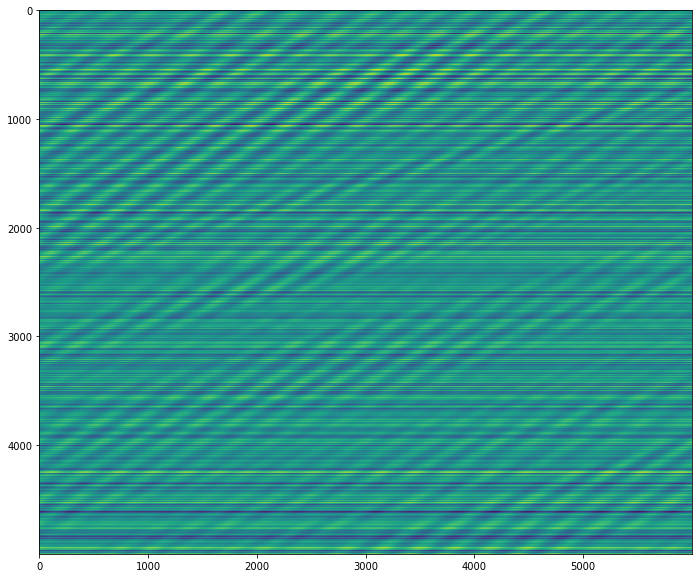

In [44]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat[:,:]*10**6, vmin=-5.,vmax=5.)
plt.show()

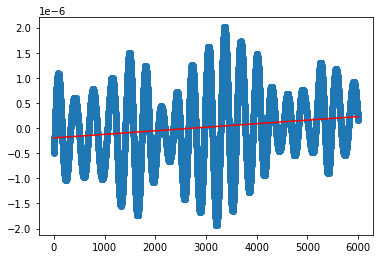

In [45]:
plt.figure()
plt.scatter(A_channel[:,0],full_dat[587,:])
plt.plot(A_channel[:,0],coeffs[587,0]*A_channel[:,0] + coeffs[587,1],c='r')

plt.show()

In [46]:
dt=1. #/200
working_dat = drift_removal[:,:]*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

# time = dt*np.arange(working_dat.shape[0])

In [47]:
xs.shape

(5000,)

In [48]:
# library_functions = [lambda x: x, lambda x: x * x]
# library_function_names = [lambda x: x, lambda x: x + x]
# pde_lib = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     derivative_order=4,
#     spatial_grid=xs,
#     include_bias=True,
#     is_uniform=True,
# #     periodic=True
# )

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

In [57]:
thresh = 0.3
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f109c94e250>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.3))

In [58]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.3
(x0)' = -936.212 x0_111 + -0.339 x0x0x0_111


In [58]:
thresh = 0.05
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff167a316d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.05))

In [59]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.235 x0_1 + 0.107 x0_111


In [54]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff167a316d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [55]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.265 x0_1 + 0.123 x0_111 + -0.070 x0x0x0_1 + -0.035 x0x0x0_111
